In [257]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Teste

In [258]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.patches import cv2_imshow
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import os
import numpy
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Função read_images que irá pegar a pasta passada e o tamanho desejado de imagem e retornará os nomes, o vetor de imagens a serem utilizadas e um vetor com as labels

In [259]:
def read_images(path, image_size):
  names = []
  training_images, training_labels = [], []
  label = 0
  for dirname, subdirnames, filenames in os.walk(path):
    for subdirname in subdirnames:
        names.append(subdirname)
        subject_path = os.path.join(dirname, subdirname)
        for filename in os.listdir(subject_path):
          img = cv2.imread(os.path.join(subject_path, filename), cv2.IMREAD_GRAYSCALE)
          if img is None:
            # The file cannot be loaded as an image.
            # Skip it.
            continue
          img = cv2.resize(img, image_size)
          training_images.append(img)
          training_labels.append(label)
        label += 1
  training_images = numpy.asarray(training_images, numpy.uint8)
  training_labels = numpy.asarray(training_labels, numpy.int32)
  #print(training_images.shape)
  return names, training_images, training_labels

#Nessa célula será salvo a pasta com as imagens, o tamanho final das imagens e será chamada a função read_images

In [260]:
path_to_training_images = '/content/gdrive/MyDrive/Dataset'
training_image_size = (120, 120)
names, training_images, training_labels = read_images(path_to_training_images, training_image_size)

#Print responsável por verificar o conjunto de nomes e o vetor que contem as training labels, mais para a frente do programa será comparado o training_labels com o valor de predição

In [261]:
print(names , training_labels)

['Joao Luiz', 'Vinicius', 'Elton', 'alba'] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3]


#Mostrando um exemplo 

<class 'numpy.ndarray'>
(120, 120)
['Joao Luiz', 'Vinicius', 'Elton', 'alba']


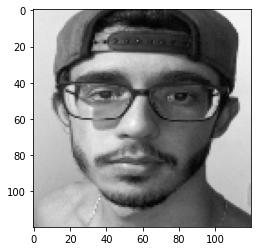

In [262]:
plt.imshow(training_images[14], cmap='gray')
print(type(training_images[0]))
print(training_images[0].shape)
print(names)

#Separando modelo de treino e teste

In [263]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(training_images, training_labels, random_state=10)

#Para predição das imagens foi necessário da um reshape

In [264]:
#nsamples, nx, ny = train_dataset.shape
#d2_train_dataset = train_dataset.reshape((nsamples,nx*ny))
nsamples_i, nx_i, ny_i = Xtrain.shape
d2_training_images = Xtrain.reshape((nsamples_i, nx_i*ny_i))

nsamples_i, nx_i, ny_i = Xtest.shape
d2_test_images = Xtest.reshape((nsamples_i, nx_i*ny_i))


#Utilizando PCA para analizar os componentes principais das fotos e armazenando, modelo utilizado é o SVM não linear

(17, 14400)
(17, 7)


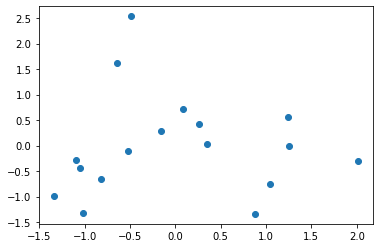

In [271]:
from sklearn.decomposition import PCA
#pca = PCA(n_components=2)

pca = PCA(n_components=7, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

print(d2_test_images.shape)
pca_images = pca.fit_transform(d2_test_images)
print(pca_images.shape)
plt.scatter(pca_images[:,0], pca_images[:,1])

#Utilizando cálculo de peso (gama e C) para treinar o modelo 

In [272]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50], 'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(pca_images, ytest)
print(grid.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


CPU times: user 226 ms, sys: 3.87 ms, total: 229 ms
Wall time: 228 ms
{'svc__C': 10, 'svc__gamma': 0.005}


#Mostrando a quantidade de imagens do Dataset


In [273]:
print(training_labels.size)
print(Xtrain.shape)
print(Xtest.shape)

68
(51, 120, 120)
(17, 120, 120)


#Predizendo os valores de pca

In [274]:
model = grid.best_estimator_
yfit = model.predict(pca_images)
print(names)
print(ytest)
print(yfit)

['Joao Luiz', 'Vinicius', 'Elton', 'alba']
[1 0 1 0 0 1 0 0 2 1 1 2 0 3 2 2 0]
[1 0 1 0 0 1 0 0 2 1 0 2 0 3 2 2 0]


#Representação visual das imagens analizadas e da predição, imagens com predição diferente da correta o texto no nome predito será em vermelho, já quando o nome predito é igual ao nome da pessoa, o texto será em preto

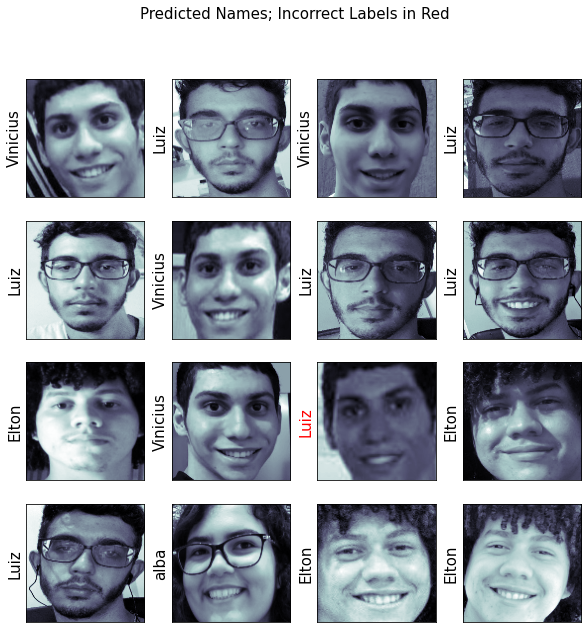

In [275]:
fig, ax = plt.subplots(4, 4, figsize = (10,10))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(120, 120), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(names[yfit[i]].split()[-1], color='black' if yfit[i] == ytest[i] else 'red', fontsize = 15)
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=15);

#Classification report para analisar em %, será observado os valores da coluna: recall

In [276]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,target_names = names))

              precision    recall  f1-score   support

   Joao Luiz       0.88      1.00      0.93         7
    Vinicius       1.00      0.80      0.89         5
       Elton       1.00      1.00      1.00         4
        alba       1.00      1.00      1.00         1

    accuracy                           0.94        17
   macro avg       0.97      0.95      0.96        17
weighted avg       0.95      0.94      0.94        17



#Parte do programa que pretende reconhecer uma face (usando o modelo treinado acima) através da entrada de imagens de um vídeo de câmera

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)
 
  return img
 
# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
 
  return bbox_bytes

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    frame = np.full([480,640,4], 0, dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray, 1.3, 5, minSize=(120, 120))
    
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      frame = cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
      gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) 
      roi_gray = gray[y:y+h, x:x+w]
      if roi_gray.size == 0:
        # The ROI is empty. Maybe the face is at the image edge.
        # Skip it.
        continue
      roi_gray = cv2.resize(roi_gray, training_image_size)
      label, confidence = model.predict(roi_gray)
      text = '%s, confidence=%.2f' % (names[label], confidence)
      print(names[label], confidence)
      cv2.putText(gray, text, (x, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    frame[:,:,3] = (frame.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(frame)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>